# Consignas

1)Desarrollar un sistema de recomendación de prestadores a partir de un modelo K-Nearest Neighbours.

Teniendo en cuenta que el perfil de los pacientes en cada especialidad muestra una marcada diferencia, desarrollar un modelo de recomendación para cada especialidad.
Utilizar modelo sklearn.neighbors.KNeighborsClassifier. La variable target será el id_prestador.
En línea con el objetivo planteado para el proyecto, el dataset de entrenamiento y validación del modelo serán aquellos prestadores que muestran altas calificaciones y un nivel de demanda medio y alto. Las altas calificaciones nos aseguran que los prestadores a recomendar brindan un buen servicio. El nivel de demanda medio/alto nos asegura que las calificaciones son representativas estadísticamente.


# Importación de librerías

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
import seaborn as sns
import ptitprince as pt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV ,  train_test_split
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Importación de datasets

In [14]:
df_procesado=pd.read_csv('../Data/df_procesado.csv')
df_procesado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 31 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   id_consumo_encoded                                                                 2500 non-null   int64  
 1   id_socio_encoded                                                                   2500 non-null   int64  
 2   id_prestador_encoded                                                               2500 non-null   int64  
 3   calificacion_experiencia_encoded                                                   2500 non-null   float64
 4   id_zona_encoded                                                                    2500 non-null   int64  
 5   edad_encoded                                                                       2500 non-null   float

In [15]:
df_procesado.head(2)

,id_consumo_encoded,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded,id_zona_encoded,edad_encoded,antiguedad_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,...,especialidad_prestador_encoded_CLINICA MEDICA,especialidad_prestador_encoded_NUTRICIONISTAS(LIC.),especialidad_prestador_encoded_PEDIATRIA,edad_cat_pediatrico,categoria_prestador_gold,categoria_prestador_silver,categoria_prestador_standard,categoria_socio_gold,categoria_socio_silver,categoria_socio_standard
0,1,100000,200000,0.666667,1,0.952941,0.530769,1,0,1,...,1,0,0,1,1,0,0,0,0,1
1,2,100000,200000,0.555556,1,0.952941,0.530769,1,0,1,...,1,0,0,1,1,0,0,0,0,1


### Análisis de demanda de prestadores

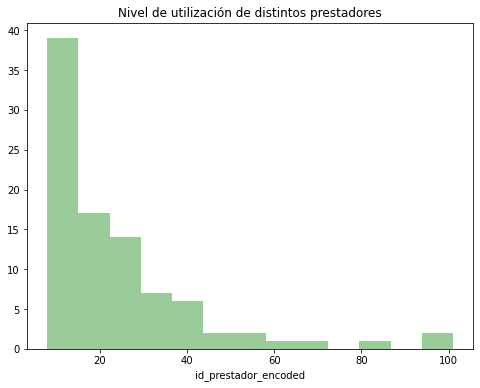

In [58]:
plt.figure(figsize=(8,6))
sns.distplot(df_procesado.id_prestador_encoded.value_counts(),kde=False,color='g')
plt.title("Nivel de utilización de distintos prestadores")
plt.show()

Partiendo del análisis realizado en los laboratorios anteriores, tenemos muchos prestadores que han sido utilizados pocas veces, mientras que hay pocos que han sido utilizados muchas veces.
Vamos a hacer una selección basándonos en medidas de tendencia central de la distribución anterior

In [38]:
df_procesado.id_prestador_encoded.value_counts().describe().reset_index()

,index,id_prestador_encoded
0,count,196.000000
1,mean,12.755102
2,std,16.324945
3,min,1.000000
4,25%,3.000000
5,50%,7.000000
6,75%,17.000000
7,max,101.000000


Vamos a filtrar utilizando el percentil 0.42

In [55]:
percetil_42=df_procesado.id_prestador_encoded.value_counts().quantile(0.42)
clientes_filtrados=df_procesado.id_prestador_encoded.value_counts()[df_procesado.id_prestador_encoded.value_counts()>median].index

In [56]:
df_procesado=df_procesado[df_procesado.id_prestador_encoded.isin(clientes_filtrados)]
df_procesado.shape

(2166, 31)

### Análisis de calificaciones

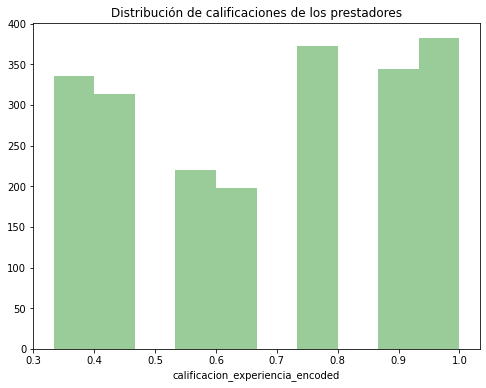

In [60]:
plt.figure(figsize=(8,6))
sns.distplot(df_procesado.calificacion_experiencia_encoded,kde=False,color='g')
plt.title("Distribución de calificaciones de los prestadores")
plt.show()

In [62]:
df_procesado.calificacion_experiencia_encoded.describe().reset_index()

,index,calificacion_experiencia_encoded
0,count,2166.000000
1,mean,0.684775
2,std,0.234282
3,min,0.333333
4,25%,0.444444
5,50%,0.777778
6,75%,0.888889
7,max,1.000000


Vamos a filtrar utilizando el percentil 0.405

In [75]:
percentil_0405=df_procesado.calificacion_experiencia_encoded.quantile(0.405)

In [76]:
df_filtrado=df_procesado[df_procesado.calificacion_experiencia_encoded>percentil_0405]

In [77]:
df_filtrado.shape

(1099, 31)

## Especialidad Clínica Médica

Filtramos los prestadores según la categoría estándar para simplificar el análisis

In [78]:
columns=['id_socio_encoded','id_prestador_encoded','calificacion_experiencia_encoded',]
df_filtrado = df_filtrado[(df_filtrado['especialidad_prestador_encoded_CLINICA MEDICA']==1)]
df_filtrado=df_filtrado[columns]

In [79]:
df_filtrado

,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded
81,100001,200001,0.777778
82,100006,200001,0.888889
83,100138,200001,1.000000
84,100277,200001,0.888889
85,100324,200001,0.888889
...,...,...,...
2256,101492,200129,1.000000
2257,101682,200129,0.888889
2258,101696,200129,0.888889
2259,101710,200129,0.777778


Tenemos varias calificaciones de un mismo socio para el mismo prestador, por lo cual calculamos el promedio de todas ellas.

In [85]:
df_filtrado[(df_filtrado.id_socio_encoded==100582    )]

,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded
784,100582,200029,0.888889
785,100582,200029,0.777778
786,100582,200029,0.888889
787,100582,200029,0.888889
788,100582,200029,0.777778


In [86]:
df_sr=df_filtrado.groupby(['id_socio_encoded','id_prestador_encoded'])['calificacion_experiencia_encoded'].mean().reset_index()
df_sr.head()

,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded
0,100001,200001,0.777778
1,100003,200002,0.888889
2,100006,200001,0.888889
3,100011,200008,0.777778
4,100015,200010,0.814815


In [87]:
df_sr[(df_sr.id_socio_encoded==100582    )]

,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded
95,100582,200029,0.844444


In [88]:
df_sr.shape

(336, 3)

In [89]:
df_pivot = df_sr.pivot_table(columns='id_socio_encoded', index='id_prestador_encoded', values="calificacion_experiencia_encoded")
df_pivot.fillna(0, inplace=True)

In [90]:
df_pivot

id_socio_encoded,100001,100003,100006,100011,100015,100037,100039,100040,100042,100049,...,101850,101853,101882,101885,101893,101902,101906,101909,101910,101919
id_prestador_encoded,,,,,,,,,,,,,,,,,,,,,
200001,0.777778,0.000000,0.888889,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
200002,0.000000,0.888889,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
200008,0.000000,0.000000,0.000000,0.777778,0.000000,0.000000,1.0,0.000000,0.000000,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.0
200010,0.000000,0.000000,0.000000,0.000000,0.814815,0.888889,0.0,0.888889,0.000000,0.0,...,0.777778,0.888889,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
200021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.777778,0.0,...,0.000000,0.000000,0.000000,0.777778,0.888889,0.0,0.000000,0.0,0.000000,0.0
200028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.777778,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.0
200029,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
200035,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
200042,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.0
